In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
from src.KLD_calculation import jsd_loop,markov_matrix
import sys
import os
sys.path.append("..")

In [2]:
os.getcwd()

'/fast/AG_Ohler/jdemoli/bachelorgit'

In [3]:

print("Torch version:", torch.__version__)
print("CUDA version in PyTorch:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA")

Torch version: 2.5.0
CUDA version in PyTorch: 12.4
Is CUDA available: True
GPU name: NVIDIA A40


In [4]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = StandardScaler()
#device = torch.device("cpu")

In [5]:
def one_hot(seqs):
    conversion_dict={
        'A':np.array([1.0,0.0,0.0,0.0]),
        'C':np.array([0.0,1.0,0.0,0.0]),
        'G':np.array([0.0,0.0,1.0,0.0]),
        'U':np.array([0.0,0.0,0.0,1.0]),
        'T':np.array([0.0,0.0,0.0,1.0]),
    }
    enc_seqs=[]
    for seq in seqs:
        enc_arr=conversion_dict[seq[0]]
        for i in seq[1:]:
            enc_arr=np.vstack((enc_arr,conversion_dict[i]))
        #enc_arr=enc_arr.T.reshape((1,4,50))
        enc_arr=torch.tensor(enc_arr.T, dtype = torch.float32)
        enc_seqs.append(enc_arr)
    enc_seqs=torch.tensor(np.array(enc_seqs),dtype = torch.float32)
        
    return enc_seqs
        
    

In [6]:
testset1=pd.read_csv('data/random_test.csv')
testset2=pd.read_csv('data/human_test.csv')
testseqs1=one_hot(list(testset1["utr"]))
testseqs2=one_hot(list(testset2["utr"]))

In [7]:
# load data
dataset1 = pd.read_csv('data/random_train_pc.csv')
trainseqs1 = one_hot(list(dataset1["utr"]))
trainmrl1 = dataset1['rl'].values.reshape([-1,1])
scaledmrl1 = torch.tensor(scaler.fit_transform(trainmrl1).reshape([-1]),dtype = torch.float32)

dataset1_reshaped=list(zip(trainseqs1,scaledmrl1))
batch_size=128
#Daten müssen zu 2 arrays werden= sequenz und mrl


In [8]:
human_dataset=pd.read_csv('data/human_val.csv')
humanseqs1=one_hot(list(human_dataset["utr"]))
humanmrl1=human_dataset['rl'].values.reshape([-1,1])
scaledhumanmrl1=torch.tensor(scaler.transform(humanmrl1).reshape([-1]),dtype = torch.float32)
human_val=list(zip(humanseqs1,scaledhumanmrl1))


In [9]:
trainloader=torch.utils.data.DataLoader(dataset1_reshaped ,batch_size=batch_size,shuffle=True)


In [62]:
valloader=torch.utils.data.DataLoader(human_val,batch_size=batch_size,shuffle=False)

In [11]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(4, 120, kernel_size=8, padding='same')
        self.conv2 = nn.Conv1d(120, 120, kernel_size=8, padding='same')
        self.conv3 = nn.Conv1d(120, 120, kernel_size=8, padding='same')
        self.flat1 = nn.Flatten()
        self.fc1 = nn.Linear(6000, 40)
        self.drop1 = nn.Dropout(0.2)
        self.out = nn.Linear(40, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = self.flat1(x)
        #x= torch.transpose(x, 1, 2)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = self.out(x)
        return x

In [12]:
net=Model()
net.to(device)

Model(
  (conv1): Conv1d(4, 120, kernel_size=(8,), stride=(1,), padding=same)
  (conv2): Conv1d(120, 120, kernel_size=(8,), stride=(1,), padding=same)
  (conv3): Conv1d(120, 120, kernel_size=(8,), stride=(1,), padding=same)
  (flat1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6000, out_features=40, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=40, out_features=1, bias=True)
)

In [13]:
criterion = nn.MSELoss()#(aL-y)^2
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.999))#epsilon ist standradmäßig bei 1e-8
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [14]:
torch.save(net.state_dict(),'models/untrained.pt')

In [15]:
def earlystopper(val_loss,patience=10,epsilon=1e-7):
    global es_stopcounter
    global es_min_loss
    if patience >= es_stopcounter: 
        if val_loss <= es_min_loss - epsilon:
            es_min_loss = val_loss
            es_stopcounter = 0
        else:
            es_stopcounter += 1
        return False
    else:
        if val_loss <= es_min_loss - epsilon:
            es_min_loss = val_loss
        else:
            es_stopcounter += 1
        return True
        
    

In [16]:
def train_one_epoch(epoch,trainloader,valloader):
    net.train(True)
    global loss_plot
    global val_plot
    global batch_plot
    global val_batch_plot
    global es_min_loss
    global min_batch_plot
    global stopcondition

    running_loss = 0.0
    val_running_loss = 0.0
    for batch_index, data in enumerate(trainloader):
        inputs, correct_mrl = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()  # flush gradient
        outputs = net(inputs)  # shape:
        outputs = torch.reshape(outputs, (-1,))
        loss = criterion(outputs, correct_mrl)
        loss_plot.append(loss.item())
        batch_plot.append(batch_index+1+epoch*len(trainloader))
        loss.backward()
        optimizer.step()

        
        for val_batch_index, val_data in enumerate(valloader):
            val_inputs, val_correct_mrl = val_data[0].to(device), val_data[1].to(device)
            val_outputs = net(val_inputs)
            val_outputs = torch.reshape(val_outputs, (-1,))
            val_loss = criterion(val_outputs, val_correct_mrl)
            val_running_loss += val_loss.item()
        val_mean_loss=val_running_loss/len(valloader)
        val_plot.append(val_mean_loss)
        val_batch_plot.append(batch_index+1+epoch*len(trainloader))
        val_running_loss = 0.0
        tmp_min=es_min_loss
        if earlystopper(val_mean_loss,patience=0.5*len(trainloader),epsilon=1e-7):
            print(f'Stopping at epoch {epoch+1}, batch{batch_index+1}')
            stopcondition = False
            break
        if es_min_loss!=tmp_min:
            min_batch_plot.append(batch_index+1+epoch*len(trainloader))
            minimum_plot.append(es_min_loss)
#auf drei epochen testen



In [ ]:
untrained_random_mrl=net(testseqs1.to(device)).cpu().detach().numpy().reshape(-1,)
untrained_human_mrl=net(testseqs2.to(device)).cpu().detach().numpy().reshape(-1,)

In [21]:
net.load_state_dict(torch.load("models/untrained.pt",weights_only=False))
print('done')

done


In [86]:
sorted_random_seqs=pd.read_csv('data/JSD_random_seqs.csv')
human_train_seqs=pd.read_csv('data/human_train.csv')



correct_random_mrl=np.array(testset1["rl"])
correct_human_mrl=np.array(testset2["rl"])
len(human_train_seqs)

20000

In [ ]:
batch_plot=[]
loss_plot=[]
val_plot=[]
val_batch_plot=[]
es_stopcounter = 0
es_min_loss=np.inf
minimum_plot=[]
min_batch_plot=[]

r2_rt_plot=[]
r2_ht_plot=[]

'''
dataset1 = pd.read_csv('data/random_train_pc.csv')
trainseqs1 = one_hot(list(dataset1["utr"]))
trainmrl1 = dataset1['rl'].values.reshape([-1,1])
scaledmrl1 = torch.tensor(scaler.fit_transform(trainmrl1).reshape([-1]),dtype = torch.float32)

dataset1_reshaped=list(zip(trainseqs1,scaledmrl1))
batch_size=128
'''

#New training loop
for i in np.arange(0,1.1,0.1):
    net.load_state_dict(torch.load("models/untrained.pt",weights_only=False))
    #Generate Training dataset
    #10% of sorted randomseqs every iteration
    nextstep_dataset=pd.concat([human_train_seqs,sorted_random_seqs.loc[0:i*len(sorted_random_seqs)-1]],ignore_index=True)
    nextstep_seqs=one_hot(list(nextstep_dataset['utr']))
    nexstep_mrl=nextstep_dataset['rl'].values.reshape([-1,1])
    nextstep_scaled_mrl=torch.tensor(scaler.fit_transform(nexstep_mrl).reshape([-1]),dtype = torch.float32)
    nextstep_train=list(zip(nextstep_seqs,nextstep_scaled_mrl))
    trainloader=torch.utils.data.DataLoader(nextstep_train,batch_size=batch_size,shuffle=True)
    
    #Actual Training
    stopcondition=True
    epoch=0
    print(f'Dataset = Human(20000) + {int(i*100)}% JSD sampled({int(i*len(sorted_random_seqs))})')
    while stopcondition:
        print(f'Epoch {epoch+1}')
        train_one_epoch(epoch,trainloader,valloader)
        epoch+=1
        
    torch.save(net.state_dict(),f'models/JSD_trained_h{int(i*100)}.pt')
        

    #Getting the outputs of network
    trained_scaled_random_mrl = net(testseqs1.to(device)).cpu().detach().numpy().reshape(-1, )
    trained_scaled_human_mrl = net(testseqs2.to(device)).cpu().detach().numpy().reshape(-1, )
    trained_random_mrl = scaler.inverse_transform(trained_scaled_random_mrl.reshape([-1, 1])).reshape(-1, )
    trained_human_mrl = scaler.inverse_transform(trained_scaled_human_mrl.reshape([-1, 1])).reshape(-1, )
    print(len(correct_human_mrl))
    print(len(trained_random_mrl))
    
    #recording R^2
    hr2=pearsonr(correct_human_mrl,trained_human_mrl)[0]**2
    print(hr2)
    r2_ht_plot.append(hr2)
    rr2=pearsonr(trained_random_mrl,trained_random_mrl)[0]**2
    print(rr2)
    r2_rt_plot.append(rr2)


Dataset = Human(20000) + 0.0% JSD sampled(-1)
Epoch 1
Stopping at epoch 1, batch106
5000
20000
0.1487526235697999
1.0
Dataset = Human(20000) + 10.0% JSD sampled(25999)
Epoch 1
Epoch 2
Stopping at epoch 2, batch328
5000
20000
0.6478320363075238
0.99999976
Dataset = Human(20000) + 20.0% JSD sampled(51999)
Epoch 1
Stopping at epoch 1, batch101
5000
20000
0.09610499203875392
0.9999999


In [ ]:
pickle.dump([batch_plot,val_batch_plot,loss_plot,val_plot], open('data/plot_vals.pkl', 'wb'))


In [ ]:
plot_val=pickle.load(open('data/plot_vals.pkl','rb'))
batch_plot=plot_val[0]
val_batch_plot=plot_val[1]
loss_plot=plot_val[2]
val_plot=plot_val[3]

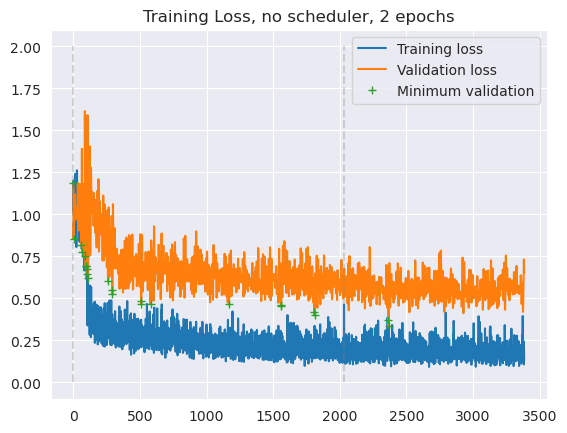

In [27]:
%matplotlib inline
plt.plot(batch_plot,loss_plot,label='Training loss')
plt.plot(val_batch_plot,val_plot,label='Validation loss')
plt.vlines(np.arange(0,len(batch_plot)+1,len(trainloader)),0,2,linestyles='dashed',alpha=0.3,color='grey')
plt.plot(min_batch_plot,minimum_plot,linestyle='none',marker='+',label='Minimum validation')
#plt.xlim()
plt.legend()
plt.title(f'Training Loss, no scheduler, {epoch} epochs')
plt.show()

In [ ]:
len(batch_plot)/3

In [ ]:
torch.save(net.state_dict(),'data/random_noscheduler.pt')

In [ ]:
torch.load("data/random_unval.pt",)

# Plotsektion

In [ ]:
net.load_state_dict(torch.load('data/random_unval.pt',weights_only=True))

In [20]:
trained_random_mrl=net(testseqs1.to(device)).cpu().detach().numpy().reshape(-1,)
trained_human_mrl=net(testseqs2.to(device)).cpu().detach().numpy().reshape(-1,)

In [21]:
trained_random_mrl = scaler.inverse_transform(trained_random_mrl.reshape([-1,1])).reshape(-1,)
trained_human_mrl = scaler.inverse_transform(trained_human_mrl.reshape([-1,1])).reshape(-1,)

Text(0.5, 1.0, 'trained model(3epochs) mrl prediction on human data')

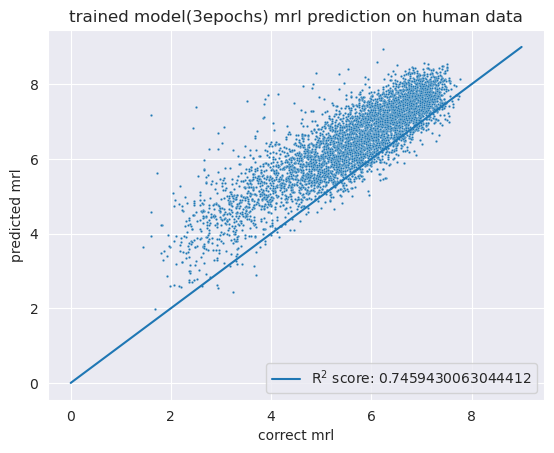

In [24]:
%matplotlib inline
sns.scatterplot(x=correct_human_mrl,y=trained_human_mrl,s=3)
sns.lineplot(x=np.linspace(0,9,num=10),y=np.linspace(0,9,num=10),label=f'R$^2$ score: {pearsonr(correct_human_mrl,trained_human_mrl)[0]**2}')
#plt.xlim(0,10)
#plt.ylim(0,10)
plt.xlabel("correct mrl")
plt.ylabel("predicted mrl")
plt.legend(loc='lower right')
plt.title(f"trained model({epoch_number}epochs) mrl prediction on human data")

In [ ]:
np.sqrt(0.1)

In [ ]:
plt.plot(np.arange(1,20001,1),untrained_random_mrl,linestyle='None',marker='o',color='blue',markersize=1)
plt.plot(np.arange(1,20001,1),correct_random_mrl,linestyle='None',marker='o',color='red',markersize=1)


In [ ]:
min(batch_plot)

In [ ]:
epoch=0
for i in range(len(batch_plot)):
    batch_plot[i]=batch_plot[i]+epoch*1981
    print(batch_plot[i])
    if batch_plot[i] == 1981:
        epoch+=1
        

In [ ]:
sns.lineplot(x=np.arange(1,302941,1),y=val_plot)
sns.lineplot(x=np.arange(1,302941,1),y=batch_plot)
plt.xlim(0,153)
plt.ylim(0,50)

In [ ]:
%matplotlib qt
plt.plot(batch_plot,loss_plot, color='blue',markersize=1,label='Loss')
plt.plot(val_batch_plot,val_plot, color='orange',markersize=1,label='Validation')
plt.title('Loss vs Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

In [ ]:
avg_loss=[]
running_loss=0
for i in range(len(loss_plot)):
    running_loss+=loss_plot[i]
    if i%30==29:
        avg_loss.append(running_loss/30)
        running_loss=0
len(avg_loss)

In [ ]:
avg_val_loss=[]
avg_batch_plot=[]
val_running_loss=0
for i in range(len(val_plot)):
    val_running_loss+=val_plot[i]
    if i%10==9:
        avg_val_loss.append(val_running_loss/10)
        avg_batch_plot.append(val_x[i])
        val_running_loss=0
len(avg_val_loss)

In [ ]:

plt.plot(avg_batch_plot,avg_loss, color='blue',markersize=1,label='Loss')
plt.plot(avg_batch_plot,avg_val_loss, color='orange',markersize=1,label='Validation')
plt.title('Loss vs Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#batch_plot=[500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000]
#plt.plot(batch_plot,loss_plot)

print((len(trainloader)-1) %200)

# JSD-Sampling

In [72]:
random_seqs=pd.read_csv('data/random_train_pc.csv')
my_random_seqs=pd.read_csv('data/random_50nt_seqs.csv')
reference_data = pd.read_csv("data/human_sample.csv")
for i in reference_data.index:
    reference_data.loc[i, 'utr'] = reference_data.loc[i, 'utr'].replace('T', 'U')

#reference_seqs = reference_data.loc[reference_data['Group'] == 'Human']
human_matrix=markov_matrix(reference_data,"utr")[2]


In [73]:
human_jsd=jsd_loop(reference_data,"utr",human_matrix,a=1)
human_jsd16=jsd_loop(reference_data,"utr",human_matrix,a=0.0625)



In [74]:
random_jsd=jsd_loop(random_seqs,"utr",human_matrix,a=1)
random_jsd16=jsd_loop(random_seqs,"utr",human_matrix,a=0.0625)

my_random_jsd=jsd_loop(my_random_seqs,"Sequence",human_matrix,a=1)
my_random_jsd16=jsd_loop(my_random_seqs,"Sequence",human_matrix,a=0.0625)

In [80]:
reference_data['JSD']=human_jsd
random_seqs['JSD']=random_jsd

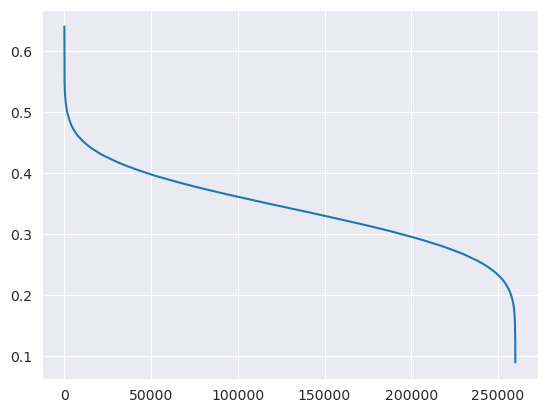

In [58]:
plt.plot(np.arange(0,len(sorted_random_seqs),1),sorted_random_seqs['JSD'].values)

In [67]:
#human_cross_jsd=pickle.load(open('data/human_jsd.pkl','rb'))
human_cross_jsd=np.load('data/human_jsd.npy')
len(human_cross_jsd)

400000000

In [70]:
bins=np.arange(0.1,0.81,0.01)
print(bins)

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51
 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65
 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8 ]


In [ ]:
human_percentile=np.percentile(human_jsd,90)
human_percentile

In [68]:
human_cross_jsd=np.sort(human_cross_jsd)
human_cjsd_subset=np.random.choice(human_cross_jsd,size=10000000)


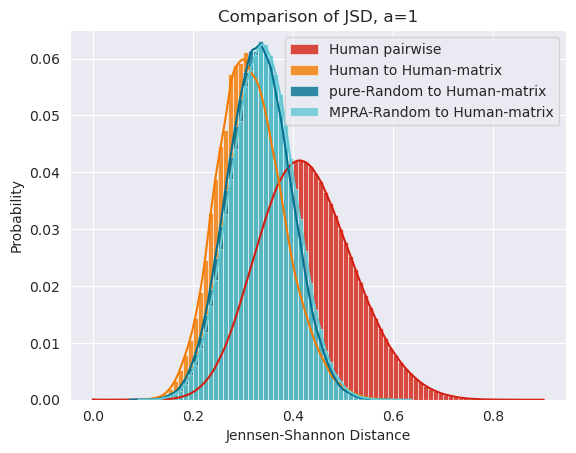

In [76]:
%matplotlib inline
sns.histplot(x=human_cjsd_subset,bins=bins,stat='probability',label='Human pairwise ',common_norm=False,color='#d31f11',alpha=0.8,kde=True)
sns.histplot(x=human_jsd,bins=bins,stat='probability',label='Human to Human-matrix',common_norm=False,color='#f47a00',alpha=0.8,kde=True)
sns.histplot(x=my_random_jsd,bins=bins,stat='probability',label='pure-Random to Human-matrix',common_norm=False,color='#007191',alpha=0.8,kde=True)
sns.histplot(x=random_jsd,bins=bins,stat='probability',label='MPRA-Random to Human-matrix',common_norm=False,color='#62c8d3',alpha=0.8,kde=True)

plt.ylim([0,0.065])

plt.xlabel("Jennsen-Shannon Distance")
plt.title("Comparison of JSD, a=1")
plt.legend()

In [ ]:
%matplotlib inline
sns.histplot(np.array(np.sqrt(human_jsd)),bins=bins,stat='probability',label='Human')
sns.histplot(np.array(random_jsd),bins=bins,stat='probability',label='Random')
plt.vlines(human_percentile,0,0.07,colors='red')
#plt.xlim([0,0.3])
plt.ylim([0,0.07])
plt.legend()
plt.show()

In [ ]:
jsd_sampled_seqs=random_seqs[random_seqs['JSD']<human_percentile]
print(len(jsd_sampled_seqs)/len(random_seqs))
my_data = pd.read_csv("data/new_dataset.csv")
my_seqs = my_data.loc[my_data['Group'] == 'Human']
my_matrix = markov_matrix(my_seqs,"Sequence")[2]
my_jsd=jsd_loop(my_seqs,"Sequence",my_matrix,a=1)
my_random_jsd=jsd_loop(random_seqs,"utr",my_matrix,a=1)

In [ ]:
sns.kdeplot(human_jsd,label='Human, Pseudocount=1',color='blue')
sns.kdeplot(random_jsd,label='Random, Pseudocount=1',color='red')
sns.kdeplot(human_jsd16,label='Human,Pseudocount=1/16',color='blue')
sns.kdeplot(random_jsd16,label='Random, Pseudocount=1/16',color='red')
plt.legend(loc='best')
plt.title('JSD distributions, pseudocount=1/16')

In [ ]:
%matplotlib inline
sns.kdeplot(human_jsd,label='Pseudocount=1')
sns.kdeplot(human_jsd2,label='Pseudocount=2')
sns.kdeplot(human_jsd05,label='Pseudocount=0.5')
sns.kdeplot(human_jsd01,label='Pseudocount=0.1')
sns.kdeplot(human_jsd16,label='Pseudocount= 1/16')#
sns.kdeplot(human_jsd001,label='Pseudocount=0.01')
plt.legend(loc='best')
plt.title('JSD distributions with different pseudocounts')
plt.show()

In [58]:
sns.histplot(np.array(my_jsd),bins=bins,stat='probability',label='Human')
sns.histplot(np.array(my_random_jsd),bins=bins,stat='probability',label='Random')
#plt.xlim([0,0.3])
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'pydev_jupyter_utils'

TypeError: range() takes no keyword arguments